# Time Marching Based Quantum Solvers for Time-dependent Linear Differential Equations

This demonstration is based on the [[1](#TimeMarching)] paper. The notebook was written in collaboration with Prof. Di Fang, the first author of the paper.

Time marching is a method for solving differential equations in time by integrating the solution vector through time in small discrete steps, where each timestep depends on previous timesteps. This paper applies an evolution matrix sequentially on the state and makes it evolve through time, as done in time-dependent Hamiltonian simulations. 

## Defining the Problem

* **Input:**  a system of linear homogenous linear equations (ODEs):

$$
\frac{d}{dt} |\psi(t)\rangle = A(t) |\psi(t)\rangle, \quad |\psi(0)\rangle = |\psi_0\rangle
$$ 

Note that $A$ can vary in time. We assume that the matrix $A$ is with bounded variation. The input model of $A(t)$ is a series of time-dependent block-encodings, described next.

* **Output:** a state that is proportional to the solution at time $T$, $|\psi(T)\rangle$.

## Describing the Algorithm

The algorithm divides the timeline into long timesteps and short timesteps. In each long timestep, some approximation of evolution of the short timesteps is done, such as the Truncated Dyson series [[2](#Dyson)] or Magnus series [[3](#Magnus)]. These are applied as block-encodings on the state, where the following matrix is block-encoded in each long timestep:
$$
\mathcal{\Xi_l} = \mathcal{T} e^{\int_{t_{l-1}}^{t_l} A(t) \, dt}
$$

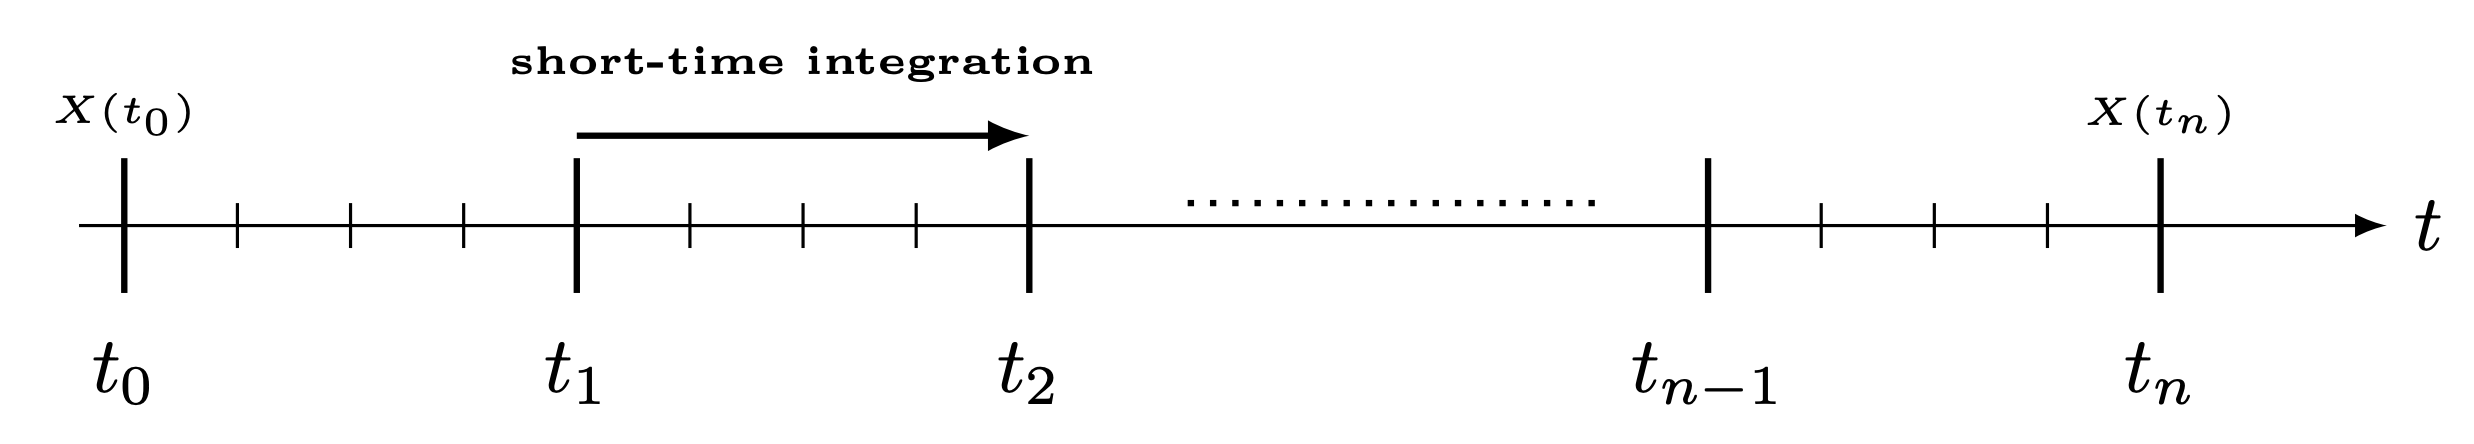

The problem is that when this block-encoding has some prefactor $s$ (for example, because some LCU is block-encoding the integration), the prefactor of the entire simulation is amplified by $s$ on each iteration. This means that the probability to sample the wanted block decreases exponentially with the number of long timesteps.

This is the main pain-point that the algorithm in the paper resolves. In the case of Hamiltonian simulation, it is possible to wrap each timestep with oblivious amplitude amplification [[4](#OAA)] (see [oblivious amplitude amplification](https://github.com/Classiq/classiq-library/blob/main/algorithms/oblivious_amplitude_amplification/oblivious_amplitude_amplification.ipynb)) and get rid of the prefactor. However, it is only possible in the case of a unitary block-encoding. The authors address this issue by using uniform singular amplitude amplification [[5](#USVA)] instead, within the QSVT framework.

## Implementing the Algorithm Using Classiq

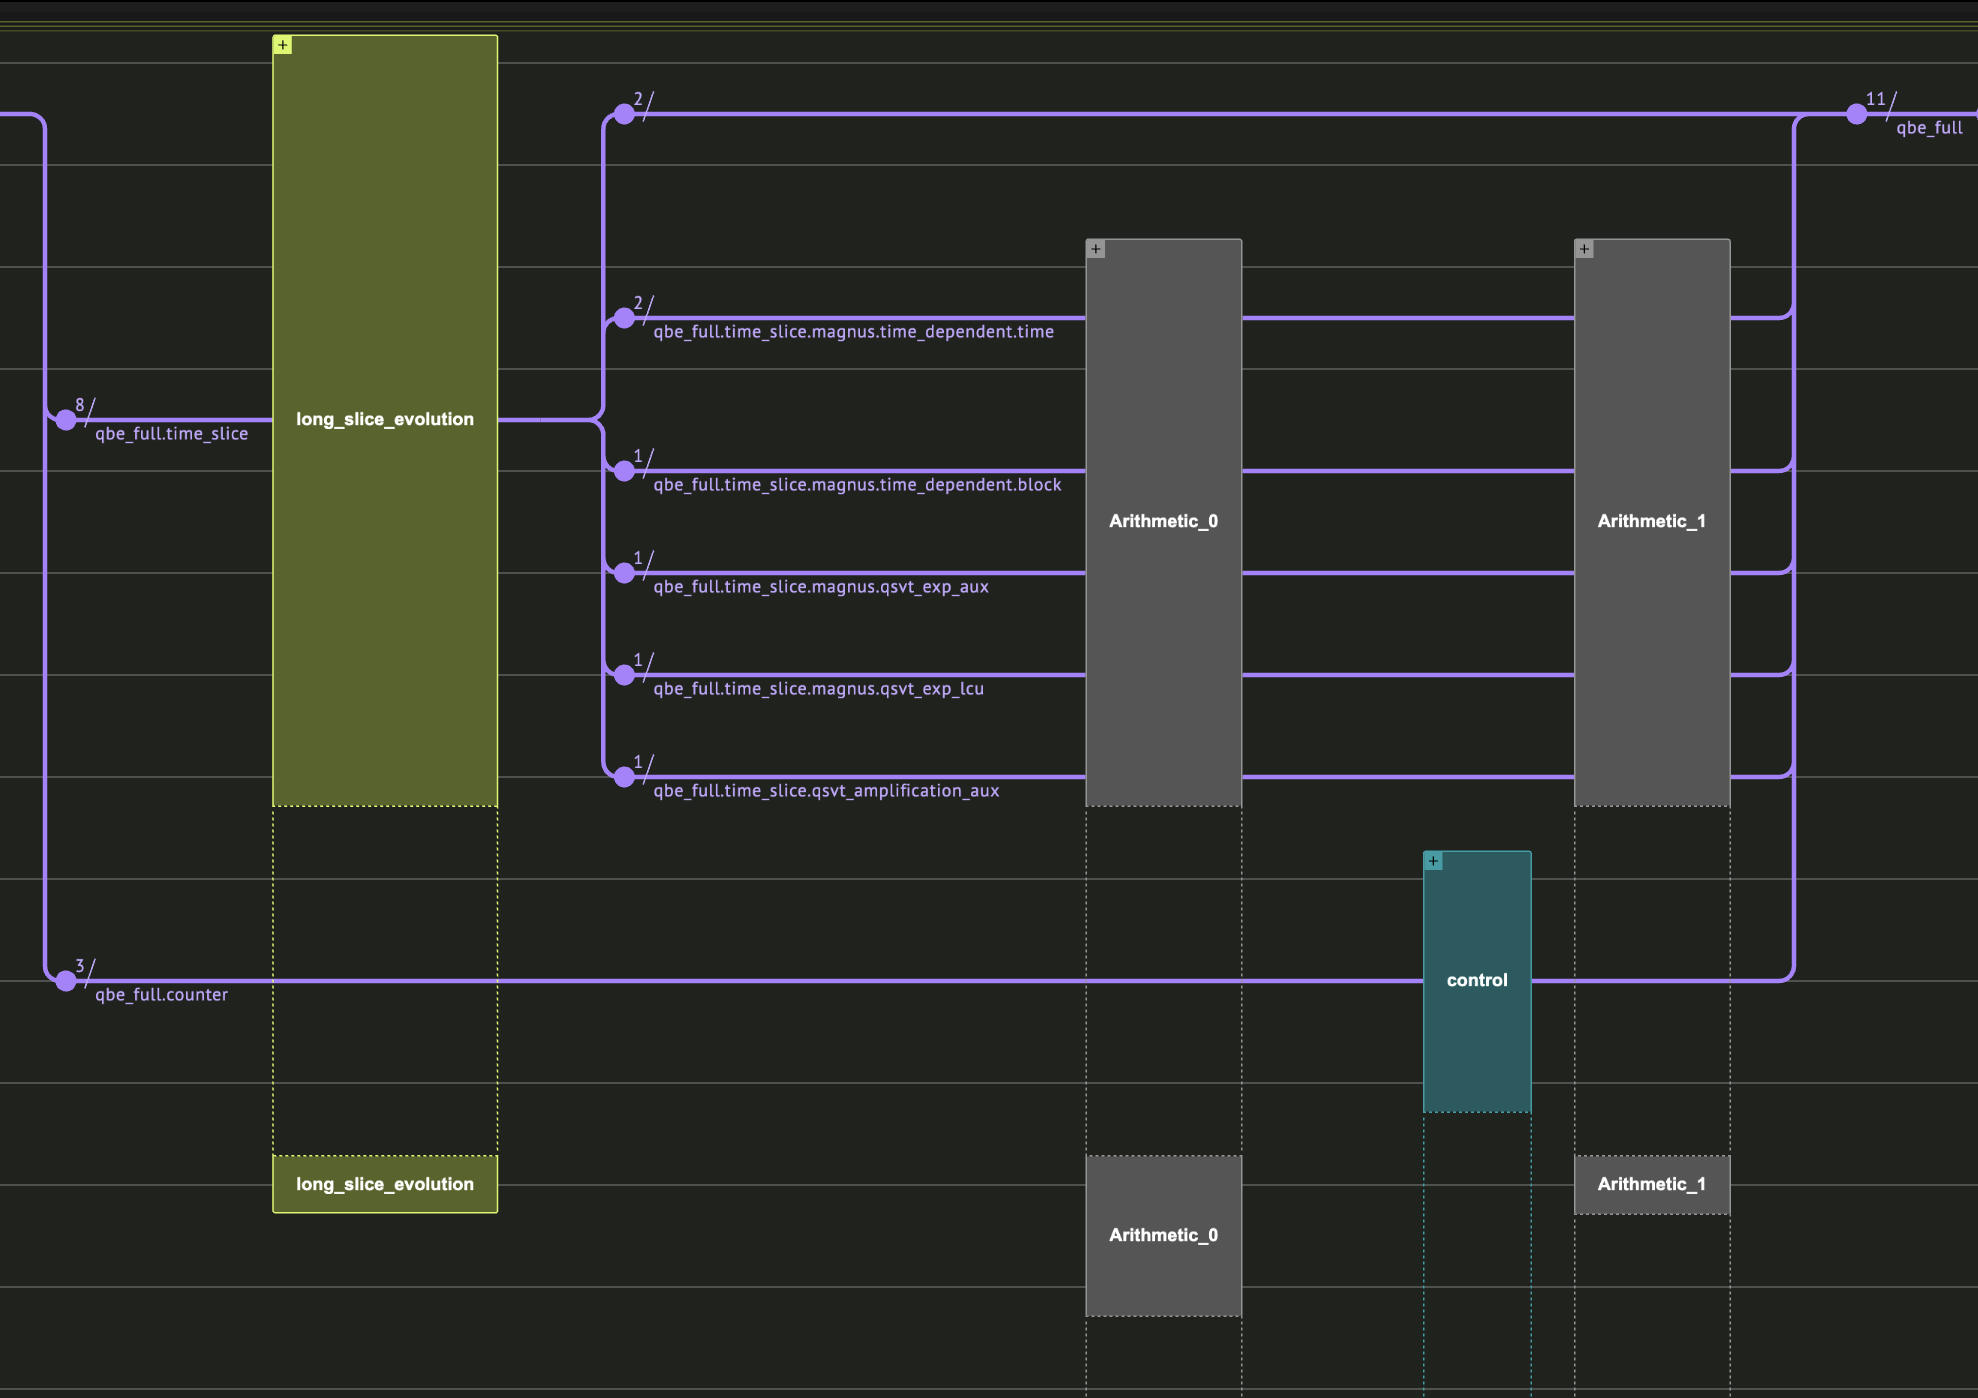

We choose an easy artificial example to demonstrate the algorithm. For simplicity, we choose $A$, which is easy to block-encode. The following matrix can be easily block-encoded using linear Pauli rotations:
$$
A_{ij}(t) = \cos(i+t)\delta_{ij}
$$

The matrix is Hermitian and diagonal, and it helps us in several aspects:
1. The first-order Magnus expansion will be exact.
2. The QSVT and QET (quantum eigenvalue transform) will coincide, and we use it to exponentiate the block-encoding.

We simulate a 4x4 matrix using four timesteps, from $t=0$ to $t=2$:

In [1]:
!pip install -qq "classiq[qsp]"

In [2]:
NUM_LONG_SLICES = 4
START_TIME = 0
END_TIME = 2

DIM_SIZE = 2

### Classical Simulation
This is how the evolution looks classically:

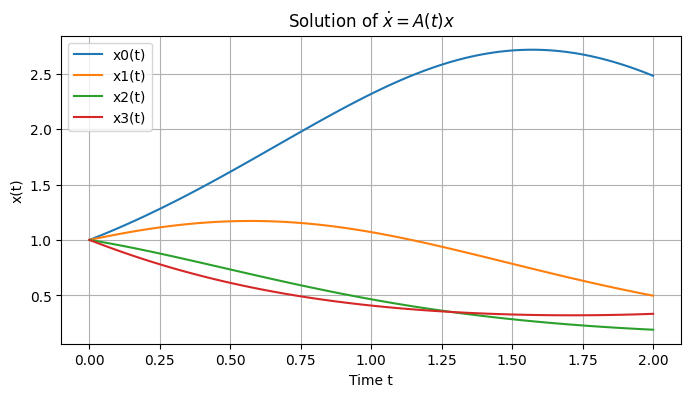

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Parameters
N = 2**DIM_SIZE  # Matrix size
t_start = 0
t_end = END_TIME


# Define the time-dependent diagonal matrix A(t)
def A(t):
    diagonal_elements = np.cos(np.arange(N) + t)  # sin(i * t) for i=0,...,N-1
    return np.diag(diagonal_elements)


# Define the ODE dx/dt = A(t)x
def ode_system(t, x):
    return A(t) @ x  # Matrix-vector multiplication


# Initial condition
x0 = np.ones(N)  # Example: start with all ones

# Solve the ODE
solution = solve_ivp(
    ode_system, [t_start, t_end], x0, t_eval=np.linspace(t_start, t_end, 100)
)

# Extract solution
t_vals = solution.t
x_vals = solution.y

# Plot the solution
plt.figure(figsize=(8, 4))
for i in range(N):
    plt.plot(t_vals, x_vals[i], label=f"x{i}(t)")

classical_final = x_vals[:, -1]
plt.xlabel("Time t")
plt.ylabel("x(t)")
plt.title(r"Solution of $\dot{x} = A(t)x$")
plt.legend()
plt.grid(True)
plt.show()

### Time-dependent Block-encoding

The time-dependent block-encoding of $A(t)$:
$$
\left( I_{n_q} \otimes \langle 0_m | \otimes I_n \right) 
U_{A(t)} 
\left( I_{n_q} \otimes | 0_m \rangle \otimes I_n \right) 
= \sum_{i=0}^{2^{n_q}-1} | i \rangle \langle i | \frac{A\left((b-a)\frac{i}{{2^{n_q}}}+a\right)}{\alpha}
$$

For a given timeslice, we get this:
$$
A_{ij}(t, a, b) = \cos((b-a)\frac{t}{2^{n_q}} + a + i)\delta_{ij}
$$

We accomplish this easily with a sequence of two Pauli rotations:

In [4]:
from classiq import *

SHORT_INTERVALS_TIME_SIZE = 2


class TimeDependentBE(QStruct):
    index: QNum[DIM_SIZE]
    time: QNum[SHORT_INTERVALS_TIME_SIZE]
    block: QBit


@qfunc
def block_encode_time_dependent_A(a: CReal, b: CReal, qbe: TimeDependentBE):
    # a factor 2 is applied on the slopes and offsets as RY rotates at half of the angle
    linear_pauli_rotations(
        [Pauli.Y], [(b - a) * 2 / (2**qbe.time.size)], [2 * a], qbe.time, qbe.block
    )
    linear_pauli_rotations([Pauli.Y], [2], [0], qbe.index, qbe.block)

### Short Time Evolution

We use a first-order Magnus expansion, which is exact in this case:
$$
\overline{\Xi} = e^{\frac{b-a}{M}} \sum_{k=0}^{M-1} A\left(a + k \frac{b-a}{M}\right)
$$
It is built in two steps.
#### 1. Riemannian Summation of Short Timesteps

By wrapping the time variable with the Hadamard transform, we get an exact block-encoding of the Reimann sum of the input block-encoding.

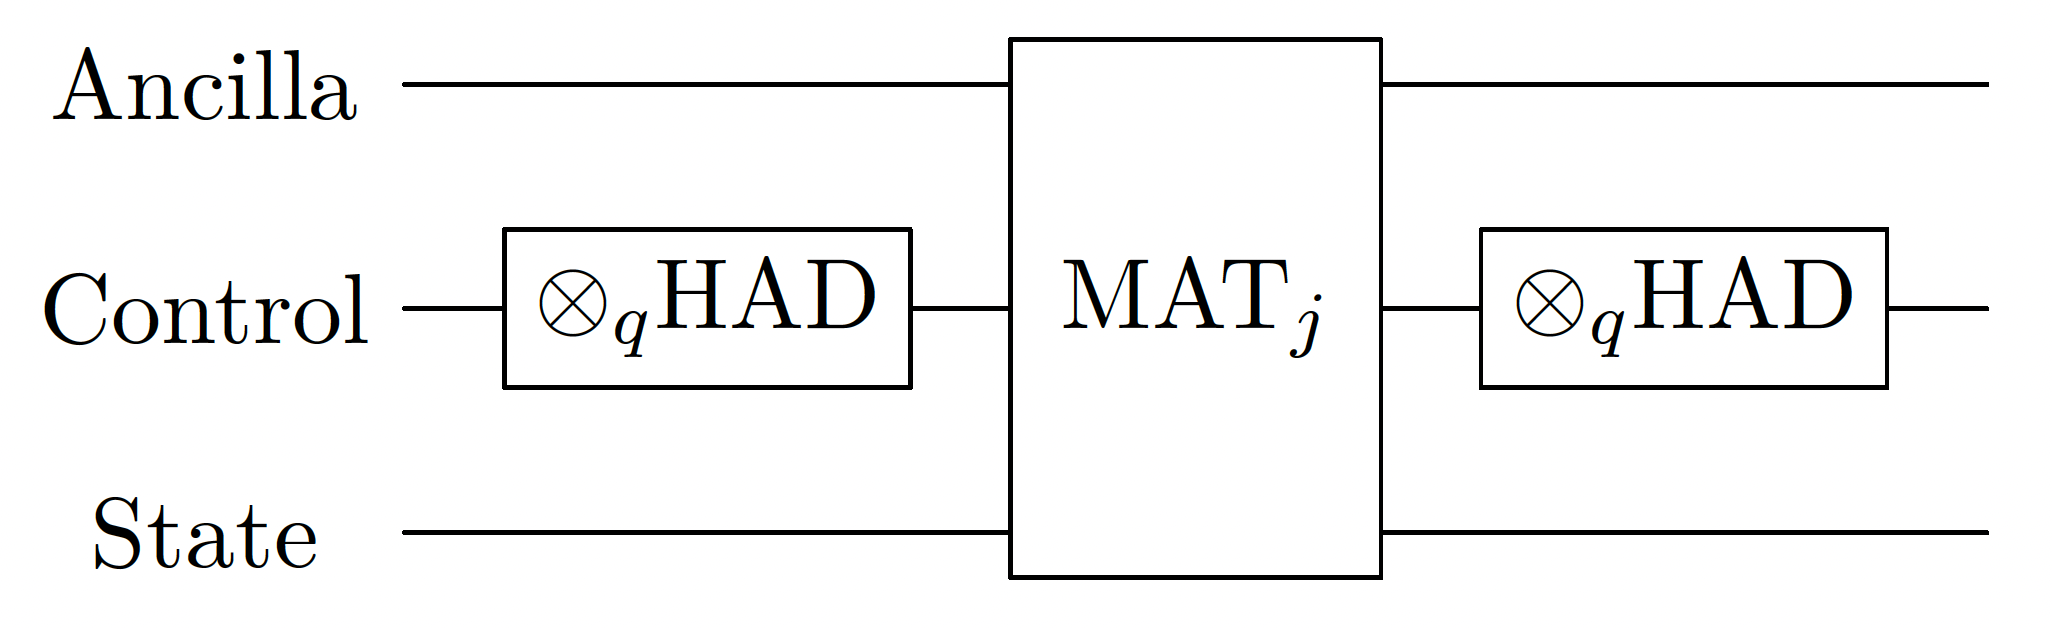

In [5]:
from classiq.qmod.symbolic import logical_and


@qfunc
def short_time_summation(a: CReal, b: CReal, qbe: TimeDependentBE):
    """
    Riemann summation
    """
    within_apply(
        lambda: hadamard_transform(qbe.time),
        lambda: block_encode_time_dependent_A(a, b, qbe),
    )


# We also define predicates for the usage later on in qsvt
def time_dependent_predicate(qbe: TimeDependentBE):
    return logical_and(qbe.block == 0, qbe.time == 0)


@qfunc
def time_dependent_projector(qbe: TimeDependentBE, is_in_block: QBit):
    is_in_block ^= time_dependent_predicate(qbe)

#### 2. Block-Encoding of the Summation Exponential

We want to find polynomials for $\cosh(ax)$ and $\sinh(ax)$, to combine them into $e^{ax}$.

For pedagogical reasons, we work naively and create a polynomial approximation for each of the odd and even polynomials of $P_{cosh} \approx \frac{\cosh(ax)}{e^a}$ and $P_{sinh} \approx \frac{\sinh(ax)}{e^a}$.

Combining them with LCU gives these results:
$$P(x) \approx \frac{e^{ax}}{2e^a},$$ which is a polynomial bounded by $\frac{1}{2}$.

We could choose $P_{cosh} \approx \frac{\cosh(ax)}{\cosh(a)}$ and $P_{sinh} \approx \frac{\sinh(ax)}{\sinh{a}}$.
Then, LCU with coefficients $[\frac{\cosh(a)}{\cosh(a)+\sinh(a)}, \frac{\sinh(a)}{\cosh(a)+\sinh(a)}]$ gives us this:
$$P(x) \approx \frac{e^{ax}}{e^a},$$
which is the best we can get, and doesn't require amplification. We go with the first approach for demonstrating the singular value amplification. Getting rid of this redundant factor 2 can save us a multiplicative factor of $O(2^T)$ in the success probability.

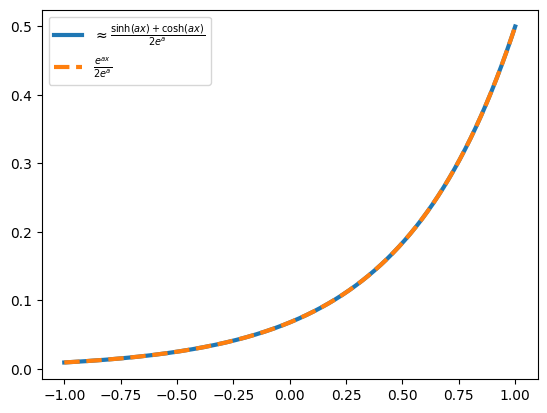

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev

from classiq.applications.qsp import qsp_approximate


def normalized_cosh(a, x):
    normalization = np.abs(np.exp(a * 1))
    return np.cosh(a * x) / normalization


def normalized_sinh(a, x):
    normalization = np.abs(np.exp(a * 1))
    return np.sinh(a * x) / normalization


A = 2
DEGREE_EXP = 7
poly_coeffs_sinh, opt_res = qsp_approximate(lambda x: normalized_sinh(A, x), DEGREE_EXP)
poly_coeffs_cosh, opt_res = qsp_approximate(
    lambda x: normalized_cosh(A, x), DEGREE_EXP - 1
)
poly_sinh = Chebyshev(poly_coeffs_sinh, domain=[-1, 1])
poly_cosh = Chebyshev(poly_coeffs_cosh, domain=[-1, 1])
x = np.linspace(-1, 1, 1000)
plt.plot(
    x,
    (0.5 * (poly_sinh + poly_cosh)(x)),
    label=r"$\approx \frac{\sinh(ax)+\cosh(ax)}{2e^a}$",
    linewidth=3,
)
plt.plot(
    x,
    np.exp(A * x) / (2 * np.exp(A)),
    "--",
    label=r"$\frac {e^{ax}}{2e^a}$",
    linewidth=3,
)
plt.legend()

We transform the polynomials to QSVT phases using the `qsvt_phases` function, and plug them into the `qsvt_lcu` function, which is optimized for implementing a linear combination of two QSVT sequences:

In [7]:
from classiq.applications.qsp import qsvt_phases


class MagnusBE(QStruct):
    time_dependent: TimeDependentBE
    qsvt_exp_aux: QBit
    qsvt_exp_lcu: QBit


@qfunc
def short_time_magnus(a: CReal, b: CReal, qbe_st: MagnusBE):
    # compute the coefficient of the expoenent
    timeslice_duration = (END_TIME - START_TIME) / NUM_LONG_SLICES
    poly_coeffs_sinh, opt_res = qsp_approximate(
        lambda x: normalized_sinh(timeslice_duration, x), DEGREE_EXP
    )
    poly_coeffs_cosh, opt_res = qsp_approximate(
        lambda x: normalized_cosh(timeslice_duration, x), DEGREE_EXP - 1
    )
    phases_sinh = qsvt_phases(poly_coeffs_sinh)
    phases_cosh = qsvt_phases(poly_coeffs_cosh)

    within_apply(
        lambda: H(qbe_st.qsvt_exp_lcu),
        lambda: qsvt_lcu(
            phases_cosh,
            phases_sinh,
            time_dependent_projector,
            time_dependent_projector,
            lambda x: short_time_summation(a, b, x),
            qbe_st.time_dependent,
            qbe_st.qsvt_exp_aux,
            qbe_st.qsvt_exp_lcu,
        ),
    )


def magnus_predicate(qbe: MagnusBE):
    return logical_and(
        time_dependent_predicate(qbe.time_dependent),
        logical_and(qbe.qsvt_exp_aux == 0, qbe.qsvt_exp_lcu == 0),
    )


@qfunc
def magnus_projector(qbe: MagnusBE, is_in_block: QBit):
    is_in_block ^= magnus_predicate(qbe)

### Amplification of a Single Long Timestep

At the climax of the algorithm, we wrap the Magnus evolution in an amplification step. The prefactor of the exponential block-encoding is 2, so we want to approximate the function $f(x)=2x$ in the interval $[0, \frac{1}{2}]$.

We use Classiq’s qsp_approximate to obtain the polynomial approximation. **Our built-in routine is inspired by the paper’s approach: it solves a minimax problem to determine the Chebyshev coefficients on a subinterval of $[-1, 1]$, while ensuring the resulting polynomial remains bounded on the entire interval**.

#### Singular Value Amplification ($\gamma x$)

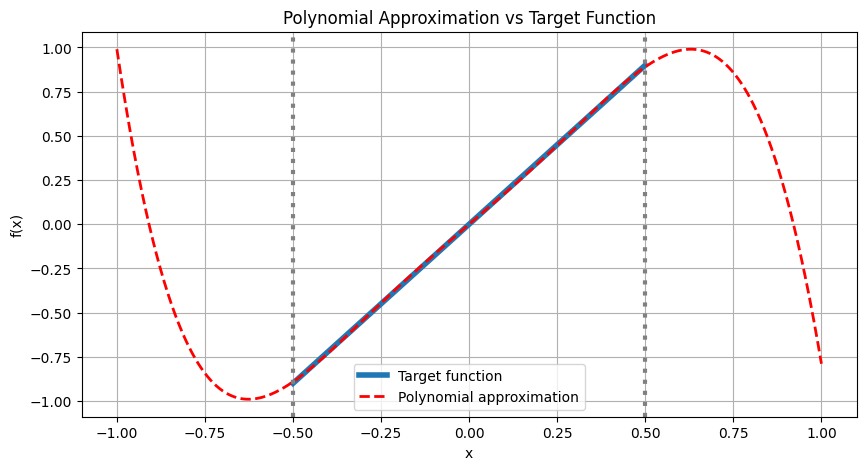

In [8]:
def target_function(gamma, x):
    return (1 - 0.1) * gamma * x


DEGREE_AMP = 7
GAMMA = 2
poly_coeffs_amp, opt_res = qsp_approximate(
    lambda x: target_function(GAMMA, x),
    interval=[-1 / GAMMA, 1 / GAMMA],
    degree=DEGREE_AMP,
    plot=True,
)
qsvt_phases_amp = qsvt_phases(poly_coeffs_amp)

Then we apply the phases on the Magnus block-encoding:

In [9]:
class LongSliceBE(QStruct):
    magnus: MagnusBE
    qsvt_amplification_aux: QBit


@qfunc
def long_slice_evolution(a: CReal, b: CReal, qbe: LongSliceBE):
    poly_coeffs_amp, opt_res = qsp_approximate(
        lambda x: target_function(2, x), interval=[-1 / 2, 1 / 2], degree=DEGREE_AMP
    )
    qsvt_phases_amp = qsvt_phases(poly_coeffs_amp)
    qsvt(
        qsvt_phases_amp,
        magnus_projector,
        magnus_projector,
        lambda x: short_time_magnus(a, b, x),
        qbe.magnus,
        qbe.qsvt_amplification_aux,
    )


def long_slice_predicate(qbe: LongSliceBE):
    return logical_and(magnus_predicate(qbe.magnus), qbe.qsvt_amplification_aux == 0)

### Long Time Evolution

Lastly, we sequentially apply the block-encodings of each timeslice. To have a quantum variable that is $|0\rangle$ when all the block encodings are applied to the state, we use a counter. A further amplitude amplification step is possible using the counter; however, we do not do it here.

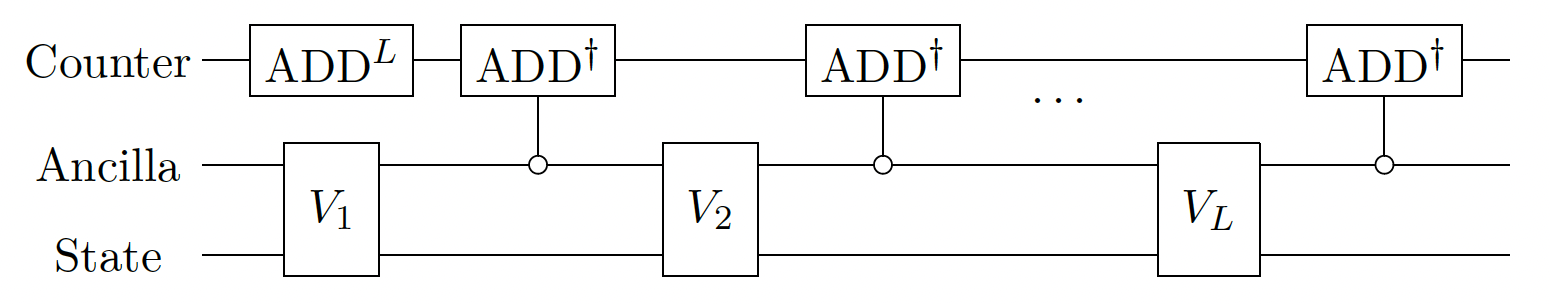

In [10]:
import numpy as np


class FullBE(QStruct):
    time_slice: LongSliceBE
    counter: QNum[np.ceil(np.log2(NUM_LONG_SLICES + 1))]


@qfunc
def long_time_integrator_step(a: CReal, b: CReal, qbe_full: FullBE):
    long_slice_evolution(a, b, qbe_full.time_slice)
    # if in block, decrement the counter
    control(
        long_slice_predicate(qbe_full.time_slice),
        lambda: inplace_add(-1, qbe_full.counter),
    )


@qfunc
def long_time_integrator(
    T: CReal, num_slices: CInt, qbe_full: FullBE  # start from time 0
):
    qbe_full.counter ^= num_slices
    repeat(
        num_slices,
        lambda i: long_time_integrator_step(
            i * T / num_slices, (i + 1) * T / num_slices, qbe_full
        ),
    )


@qfunc
def main(qbe: Output[FullBE]):
    allocate(qbe.size, qbe)

    # initial condition: uniform distribution
    hadamard_transform(qbe.time_slice.magnus.time_dependent.index)
    long_time_integrator(END_TIME, NUM_LONG_SLICES, qbe)


prefereces = Preferences(optimization_level=0, timeout_seconds=500)
execution_preferences = ExecutionPreferences(num_shots=1000000)
qmod = create_model(
    main,
    preferences=prefereces,
    execution_preferences=execution_preferences,
    out_file="time_marching",
)
qprog = synthesize(qmod)
show(qprog)
res = execute(qprog).get_sample_result()

Quantum program link: https://platform.classiq.io/circuit/32pZ9tYoR54fP4DmJyBjY63HXxh


### Comparing to the Naive Case: Without Uniform Amplification

Here we do not use the amplification step. We see that the measured amplitudes are much smaller than in the amplified case.

In [11]:
@qfunc
def long_time_integrator_step_naive(a: CReal, b: CReal, qbe_full: FullBE):
    short_time_magnus(a, b, qbe_full.time_slice.magnus)
    # if in block, decrement the counter
    control(
        magnus_predicate(qbe_full.time_slice.magnus),
        lambda: inplace_add(-1, qbe_full.counter),
    )


@qfunc
def long_time_integrator_naive(
    T: CReal, num_slices: CInt, qbe_full: FullBE  # start from time 0
):
    qbe_full.counter ^= num_slices
    repeat(
        num_slices,
        lambda i: long_time_integrator_step_naive(
            i * T / num_slices, (i + 1) * T / num_slices, qbe_full
        ),
    )


@qfunc
def main(qbe: Output[FullBE]):
    allocate(qbe.size, qbe)
    # initial condition: uniform distribution
    hadamard_transform(qbe.time_slice.magnus.time_dependent.index)
    long_time_integrator_naive(END_TIME, NUM_LONG_SLICES, qbe)


qmod_naive = create_model(
    main, preferences=prefereces, execution_preferences=execution_preferences
)
qprog_naive = synthesize(qmod_naive)
show(qprog_naive)
res_naive = execute(qprog_naive).get_sample_result()

Quantum program link: https://platform.classiq.io/circuit/32pZUdGXHjpl0u2XuLSJmTT1nuU


### Post-processing

In [12]:
def post_process_res_statevector(result):
    filtered_samples = [
        s
        for s in result.parsed_state_vector
        if s.state["qbe"]["counter"] == 0 and np.abs(s.amplitude) > 1e-6
    ]
    global_phase = np.exp(1j * np.angle(filtered_samples[0].amplitude))
    amplitudes = np.zeros(2**DIM_SIZE)
    for sample in filtered_samples:
        index = sample.state["qbe"]["time_slice"]["magnus"]["time_dependent"]["index"]
        amplitudes[index] = np.real(sample.amplitude / global_phase)
    return amplitudes


def post_process_res_samples(result):
    filtered_samples = [s for s in result.parsed_counts if s.state["qbe"].counter == 0]
    probs = np.zeros(2**DIM_SIZE)
    for sample in filtered_samples:
        index = sample.state["qbe"].time_slice.magnus.time_dependent.index
        probs[index] += sample.shots / result.num_shots
    return np.sqrt(probs)

In [13]:
amplitudes_amplified = post_process_res_samples(res)
print("amplified amplitudes:", amplitudes_amplified)

amplitudes_naive = post_process_res_samples(res_naive)
print("naive amplitudes:", amplitudes_naive)

print("classical:", classical_final)

amplified amplitudes: [0.12157714 0.02247221 0.00768115 0.01272792]
naive amplitudes: [0.01157584 0.00264575 0.001      0.00173205]
classical: [2.48301135 0.49650918 0.18886598 0.33261086]


And indeed we can see the the naive amplitudes are order of magnitude smaller than the amplified case (this is exactly what we expect for 4 timesteps).

### Comparing Classical and Quantum Results

In this final step, we verify that the classical and quantum solutions are equivalent:

In [14]:
expected = classical_final / np.linalg.norm(classical_final)
sampled = amplitudes_amplified / np.linalg.norm(amplitudes_amplified)
assert np.linalg.norm(sampled - expected) < 0.1

## References

<a id='TimeMarching'>[1]</a>: [Fang, Di, Lin, Lin, and Tong, Yu. Time-marching based quantum solvers for time-dependent linear differential equations. Quantum 7, 955 (2023).](https://doi.org/10.22331/q-2023-03-20-955)

<a id='Dyson'>[2]</a>: [M. Kieferov a, A. Scherer, and D. W. Berry. Simulating the dynamics of timedependent
Hamiltonians with a truncated Dyson series. Phys. Rev. A, 99(4), Apr
2019](https://arxiv.org/abs/1805.00582).

<a id='Magnus'>[3]</a>: [Magnus Expansion (Wikipedia)](https://en.wikipedia.org/wiki/Magnus_expansion).

<a name='OAA'>[4]</a>: [Berry, Dominic W., et al. Exponential improvement in precision for simulating sparse Hamiltonians. Proceedings of the forty-sixth annual ACM symposium on Theory of Computing. 2014.](https://dl.acm.org/doi/abs/10.1145/2591796.2591854)


<a name='USVA'>[5]</a>: [A. Gily en, Y. Su, G. H. Low, and N. Wiebe. Quantum singular value transformation and
beyond: exponential improvements for quantum matrix arithmetics. In Proc. 51st Annu.
ACM SIGACT Symp. Theory Comput., pages 193{204, 2019.](https://dl.acm.org/doi/10.1145/3313276.3316366)